## K-Means++ 

### Handle latitude/longitude in predictions 


In [1]:
from nextbike.io import input, output
from nextbike.model.utils import prepare_data
from nextbike.model.clustering import cluster
from nextbike.model.classification.logistic_regression import *
from nextbike.model.regression import polynomial_regression
from nextbike.model.regression.linear_regression import __init__, linear_regression, lasso_regression, compare_linear_regression_models
from nextbike.model.regression.parameters import model_dic


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [4]:
# read in the trip data 
df_final = input.read_csv(loc='processed', name = "dortmund_trips.csv", index_col=0)

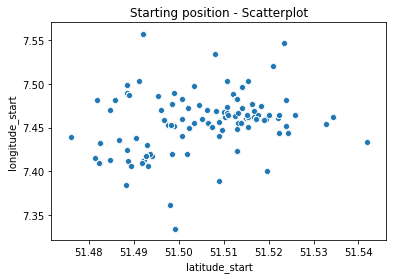

In [8]:
# scatterplot for starting positions of trips 
sns.scatterplot(x="latitude_start", y = "longitude_start", data=df_final)
plt.title("Starting position - Scatterplot")
plt.show()

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


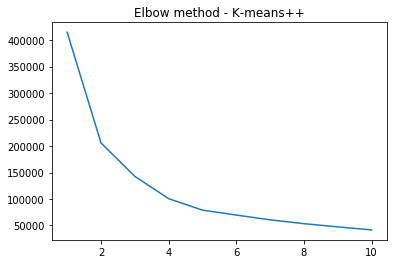

In [9]:
cluster_value = cluster.elbow_method(df_final)

In [12]:
cluster_value["X_scaled"]

array([[-0.06964911,  0.57295495],
       [ 0.02790325, -0.18665116],
       [-0.3267668 , -0.00998374],
       ...,
       [-1.22994233, -1.52345587],
       [ 0.95125856,  0.74855939],
       [-0.5455009 ,  0.1484004 ]])

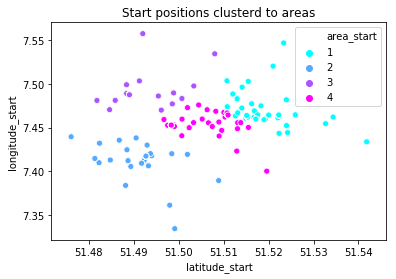

In [16]:
# due to the elbow method number of clusters are set to 4 
km = KMeans(n_clusters = 4)
km.fit(cluster_value["X_scaled"])
df_final["area_start"] = km.predict(cluster_value['X_scaled'])+1

sns.scatterplot(x="latitude_start", y="longitude_start", data=df_final, hue="area_start", palette="cool")
plt.title("Start positions clusterd to areas")
plt.show()

We get the start positions of the trips summed up to four different areas in the city (North-West, South-West, City-Center and North-East). 
This feature could be very useful for the predictions in task 3. 

In [19]:
output.write_trip_data(df_final)

Transformed trip data for Dortmund successfully saved in a csv file! 
PATH is /Users/Musti/Documents/uni/MSC/Köln/SS20/Schwerpunktbereich/Information Systems/Programming Data Science/Git/ss_20_pds/data/processed/dortmund_trips.csv


### Task 3a

### predicion university-trips with outliers

In [7]:
df_final = input.read_csv(loc='processed',name= "dortmund_trips.csv", index_col = 0)

In [8]:
df_final.describe()

,b_number,latitude_start,longitude_start,latitude_end,longitude_end,trip_duration,distance,distanceToUniversity,distanceToCentralStation,weekday,...,month,hour,minute,day_of_year,towardsUniversity,awayFromUniversity,temperature °C,precipitation in mm,precipitation,area_start
count,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,...,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000,207476.000000
mean,206360.600031,51.507129,7.456074,51.507193,7.456184,33.376010,0.907952,3.518807,1.950152,2.758546,...,7.187882,12.556942,30.104595,203.454318,0.081908,0.084819,12.309225,0.055196,0.112066,2.332588
std,213713.119581,0.011740,0.025233,0.011730,0.025143,83.413993,1.160495,1.670345,1.530168,1.915539,...,3.286835,5.812148,17.380167,100.751973,0.274226,0.278614,7.284724,0.298039,0.315448,1.297713
min,843.000000,51.476038,7.334661,51.476038,7.334661,2.000000,0.000000,0.139429,0.081884,0.000000,...,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,-8.900000,0.000000,0.000000,1.000000
25%,50846.000000,51.498563,7.444455,51.498845,7.444455,3.000000,0.000000,2.608602,0.824870,1.000000,...,4.000000,8.000000,15.000000,116.000000,0.000000,0.000000,6.700000,0.000000,0.000000,1.000000
50%,53006.000000,51.509557,7.459931,51.509557,7.459931,9.000000,0.632603,3.981653,1.368801,3.000000,...,8.000000,13.000000,30.000000,216.000000,0.000000,0.000000,11.700000,0.000000,0.000000,2.000000
75%,500100.000000,51.516234,7.469189,51.516234,7.469189,21.000000,1.339151,4.541250,3.234134,4.000000,...,10.000000,17.000000,45.000000,297.000000,0.000000,0.000000,17.200000,0.000000,0.000000,4.000000
max,500864.000000,51.541818,7.557450,51.541818,7.557450,1399.000000,10.505409,9.848994,8.864329,6.000000,...,12.000000,23.000000,59.000000,365.000000,1.000000,1.000000,35.000000,7.700000,1.000000,4.000000


In [9]:
data = prepare_data(df_final)

In [10]:
y_towards = data['towardsUniversity']
y_away = data['awayFromUniversity']

# use only start-information to classify the trip-class
X = data[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]

### These are the best parameters for logistic regression for the attribute awayFromUniversity

In [ ]:
logistic_regression.optimize_hyper_parameters(X,y_away)

### These are the best parameters for logistic regression for the attribute towardsUniversity

In [ ]:
logistic_regression.optimize_hyper_parameters(X,y_towards)

#### Performance of the models

## RandomForest
### Prediction model for both attributes separately


### AwayFromUniversity

In [ ]:
y_away = data['awayFromUniversity']

In [ ]:
optimize_hyper_parameters_random_forest(X,y_away)

### Task 3.1 Linear Models

In [4]:
df_final.describe()[["trip_duration"]]

,trip_duration
count,207476.000000
mean,33.376010
std,83.413993
min,2.000000
25%,3.000000
50%,9.000000
75%,21.000000
max,1399.000000


In [5]:
# which features correlate with trip_duration?
df_final.corr()[["trip_duration"]]

,trip_duration
b_number,-0.111455
latitude_start,0.069869
longitude_start,0.026254
latitude_end,0.024695
longitude_end,0.005166
trip_duration,1.000000
distance,0.128641
distanceToUniversity,0.035036
distanceToCentralStation,-0.067067
weekday,0.007592


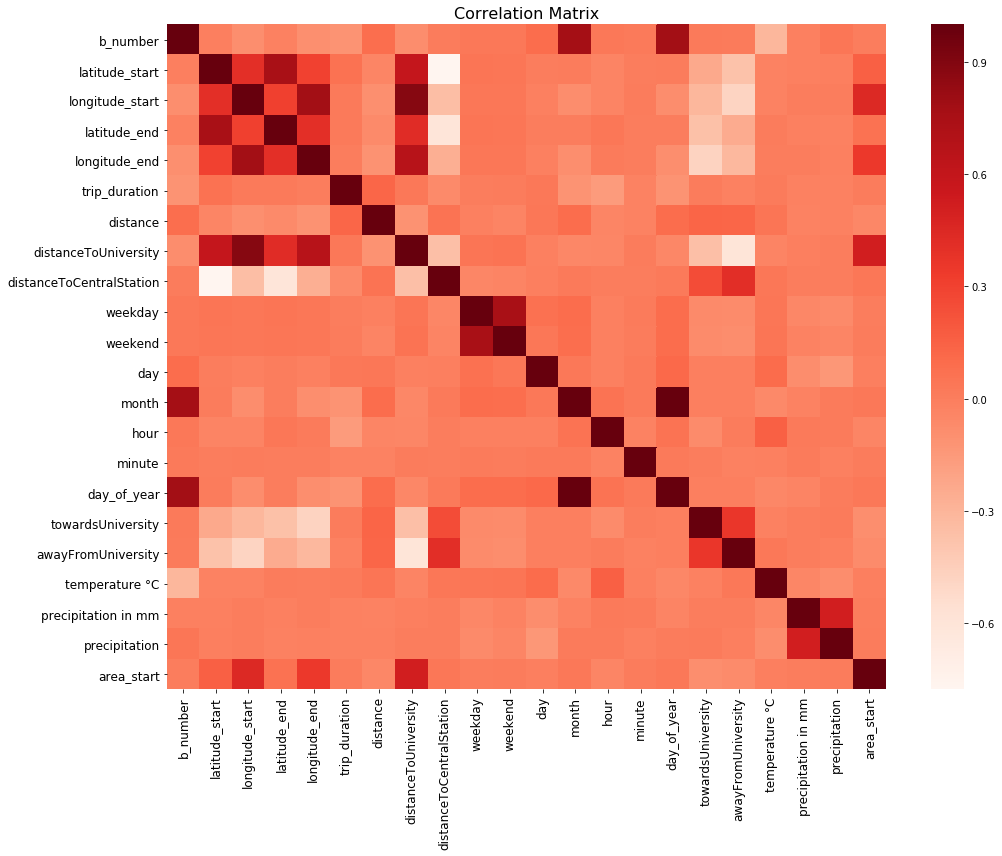

In [6]:
plt.figure(figsize=(15,12))
sns.heatmap(df_final.corr(),cmap="Reds")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.savefig("../doc/figures/CorrelationMatrix.png")
plt.show()

In [7]:
init = __init__(df_final)

# Linear Regression

In [8]:
linear_regression(init['X_train'], init['X_test'], init['y_train'], init['y_test'])

w/o cross-validaiton:
R2-Score is: 0.04267097887246729
RMSE: 80.91440614852104
MAE: 39.434336301244194

w/ cross-validation
R2-Score is: 0.04291202174004072
RMSE: 83.21234246878596
MAE: 40.129876738434234


# Lasso Regression

In [ ]:
lasso_regression(init['X_train'], init['X_test'], init['y_train'], init['y_test'])

# Ridge Regression 

In [ ]:
ridge_regression(init['X_train'], init['X_test'], init['y_train'], init['y_test'])

# Compare results Linear / Lasso / Ridge

In [ ]:
compare_linear_regression_models(init['X_train'], init['X_test'], init['y_train'], init['y_test'])

# Grid Search
## Parameter Tuning for Ridge and Lasso Regression 

In [ ]:
calculate_hyper_parameters(init['X_train'], init['X_test'], init['y_train'])

### Task 3.2 Polynominal Regression

In [5]:
from sklearn.linear_model import Lasso,Ridge, LinearRegression

In [6]:
init = polynomial_regression.__init__(df_final)

In [7]:
polynomial_regression.polynomial_reg("LinearRegression", LinearRegression(), 3, init)

w/o cross-validation:
R^2-Score is: 0.09858398956448122
RMSE: 79.31158383596177
MAE: 37.95302989859091

w/ cross-validation:
The R^2 is:  0.08782397382673734
RMSE: 79.3934188093713
MAE: 38.325607585556114


In [8]:
polynomial_regression.polynomial_reg("LinearRegression", LinearRegression(), 4, init)

KeyboardInterrupt: 

In [ ]:
polynomial_regression.polynomial_reg("Ridge", Ridge(), 3, init)

In [ ]:
polynomial_regression.polynomial_reg("Ridge", Ridge(), 4, init)